File Intro

In [2]:
# load data from csv file and print some basic information

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/ogd103_stromverbrauch_swissgrid_lv_und_endv.csv",
    header=0,
    dtype={"Landesverbrauch_GWh": "float64", "Endverbrauch_GWh": "float64"},
    na_values=["", "NaN", "NULL"]
)

df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce") # convert to datetime

df.info()
df.describe()
df.head()
df.shape

#print(df.head(10))
#print(df.tail(10))
print("Size of the dataframe: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                4113 non-null   datetime64[ns]
 1   Landesverbrauch_GWh  4113 non-null   float64       
 2   Endverbrauch_GWh     4113 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 96.5 KB
Size of the dataframe:  (4113, 3)


In [3]:
# Data Quatlity Check: stromverbruach_swissgrid
print("-------------------- Data Quality Control --------------------", '\n')


# 1. Checking for 0 Values
print("Checking for 0 Values-------------------")

zeros_landes = df[df['Landesverbrauch_GWh'] == 0]
zeros_end = df[df['Endverbrauch_GWh'] == 0]

print("First zero (Landesverbrauch):", zeros_landes["Datum"].iloc[0])
print("Last zero (Landesverbrauch):", zeros_landes["Datum"].iloc[-1])

print("First zero (Endverbrauch):", zeros_end["Datum"].iloc[0])
print("Last zero (Endverbrauch):", zeros_end["Datum"].iloc[-1])

#print(df[df["Landesverbrauch_GWh"] == 0].tail())


# 2. Checking for duplicate dates
print("Checking for duplicate dates-------------------")
print("Number of duplicate dates: ", df.duplicated(subset=['Datum']).sum())

#print("list of dates that are duplicated: ", '\n')
#print(df.loc[df.duplicated(subset=['Datum'])])

print("Number of unique dates: ", df['Datum'].nunique())

-------------------- Data Quality Control -------------------- 

Checking for 0 Values-------------------
First zero (Landesverbrauch): 2025-01-24 00:00:00
Last zero (Landesverbrauch): 2025-04-25 00:00:00
First zero (Endverbrauch): 2025-01-24 00:00:00
Last zero (Endverbrauch): 2025-04-25 00:00:00
Checking for duplicate dates-------------------
Number of duplicate dates:  1076
Number of unique dates:  3037


There are duplicate dates with different values contained within the data. In addition there are quite a few date

1. The dates with 0 values are a result of measurements taking a while and it is stated that there can be issues with the validity up to half a year back from the most recent date. Therefore a cut-off date that lies 6 months before the most recent value will be added, and all later data will be removed form the dataframe.

2. The dates with duplicate values will take on the value that was entered as the latest update, which would place is as the value at the bottom. Due to duplicate dates indicating corrections made later (based on the swiss data websites description) we will assuming that the bottom value was the "most correct" for simplicities sake.

In [4]:
# Implementing Data Frame correction based on markdown above

# 1. Applying the cut-off date that lies 6 months before the most recent date
print("size of the data frame before correction: ", df.shape)
cutoff_date = df['Datum'].max() - pd.DateOffset(months=6)
print("cutoff date: ", cutoff_date)
print("most recent date: ", df['Datum'].max())

df = df[df['Datum'] <= cutoff_date]
print("size of the data frame after correction: ", df.shape)

# 2. Dates with duplicate values will be reduced to the bottom value of that date, which holds the larges index

df = df.sort_values('Datum').drop_duplicates(subset=['Datum'], keep='last')

print("Number of unique dates after correction: ", df['Datum'].nunique())
print("size of the data frame after correction: ", df.shape)

size of the data frame before correction:  (4113, 3)
cutoff date:  2024-10-25 00:00:00
most recent date:  2025-04-25 00:00:00
size of the data frame after correction:  (3854, 3)
Number of unique dates after correction:  2855
size of the data frame after correction:  (2855, 3)


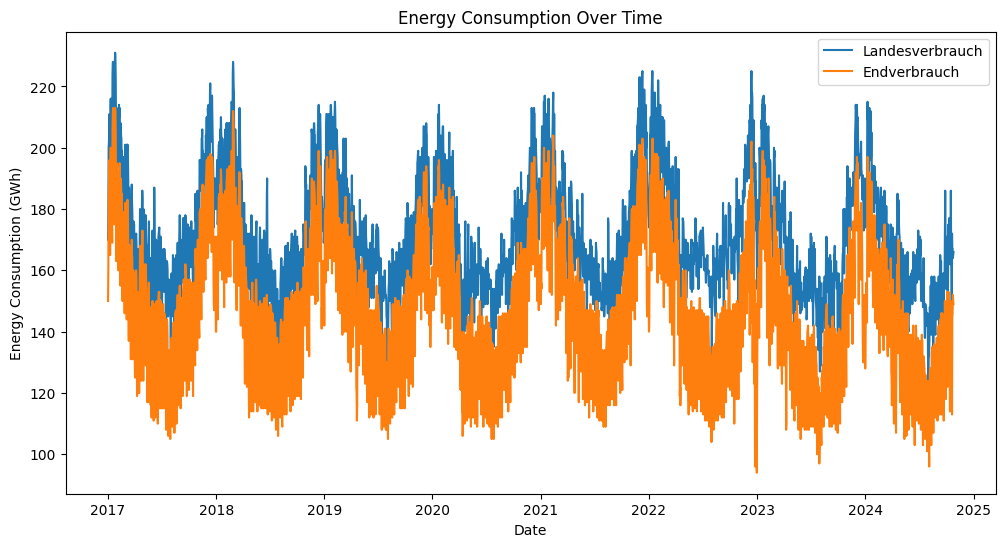

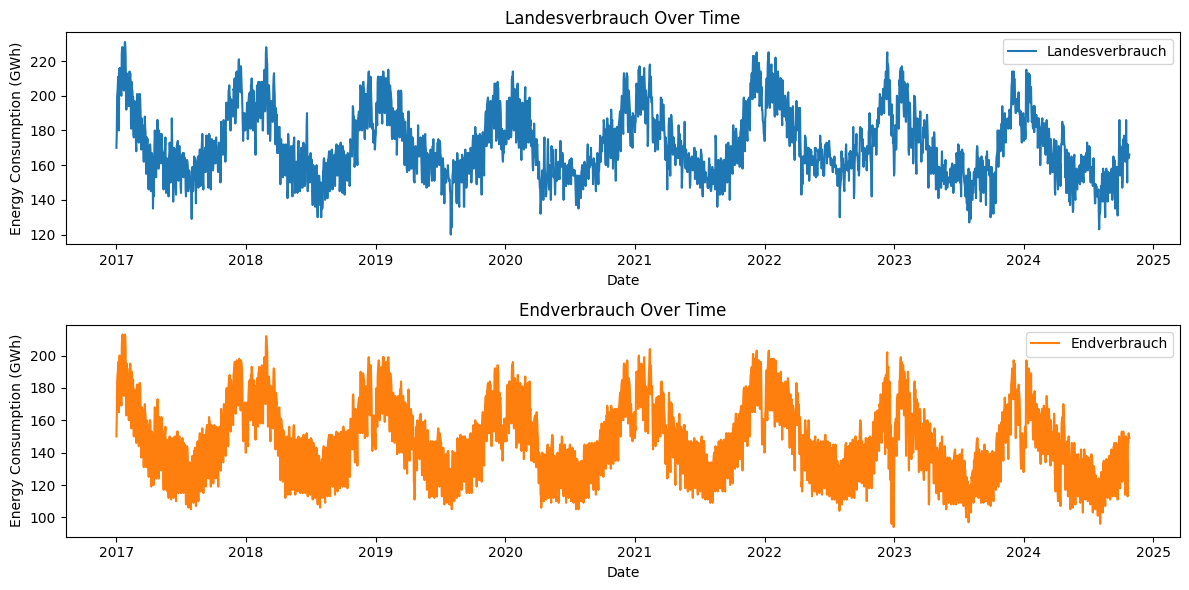

In [10]:
import matplotlib.pyplot as plt

# Define shared colors
colors = {
    "Landesverbrauch_GWh": "#1f77b4",  # blue
    "Endverbrauch_GWh": "#ff7f0e"       # orange
}

plt.figure(figsize=(12,6))
plt.plot(df["Datum"], df["Landesverbrauch_GWh"], label="Landesverbrauch", color=colors["Landesverbrauch_GWh"])
plt.plot(df["Datum"], df["Endverbrauch_GWh"], label="Endverbrauch", color=colors["Endverbrauch_GWh"])
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy Consumption (GWh)")
plt.title("Energy Consumption Over Time")
plt.show()

# plot individual columns in the same colors as above
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(df["Datum"], df["Landesverbrauch_GWh"], label="Landesverbrauch", color=colors["Landesverbrauch_GWh"])
plt.legend()
plt.title("Landesverbrauch Over Time")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (GWh)")
plt.subplot(2, 1, 2)
plt.plot(df["Datum"], df["Endverbrauch_GWh"], label="Endverbrauch", color=colors["Endverbrauch_GWh"])
plt.legend()
plt.title("Endverbrauch Over Time")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (GWh)")
plt.tight_layout()
plt.show()

The above plots showing the energy consumption of the end user and of the nation of Switzerland over time display a few paterns and remarkable features. For one, the obvious yearly fluctuation of an increased usage in the colder months due to heating, and an additional yearly dip in consumption around the new year due to holidays when most workers are at home and less energy is beign used by industry. Interestingly enough, the consumption trend doesn't seem to be increasing by much over time at first glance, a trait which should be further explored by adding up either monthly or yearly consumption. Additionally, the holidays of 2023/24 display and abnormaly low amount of energy consumed by the end user, which should also be further looked into.

Next we will take a look at the difference between the Landes- and Endverbrauch.

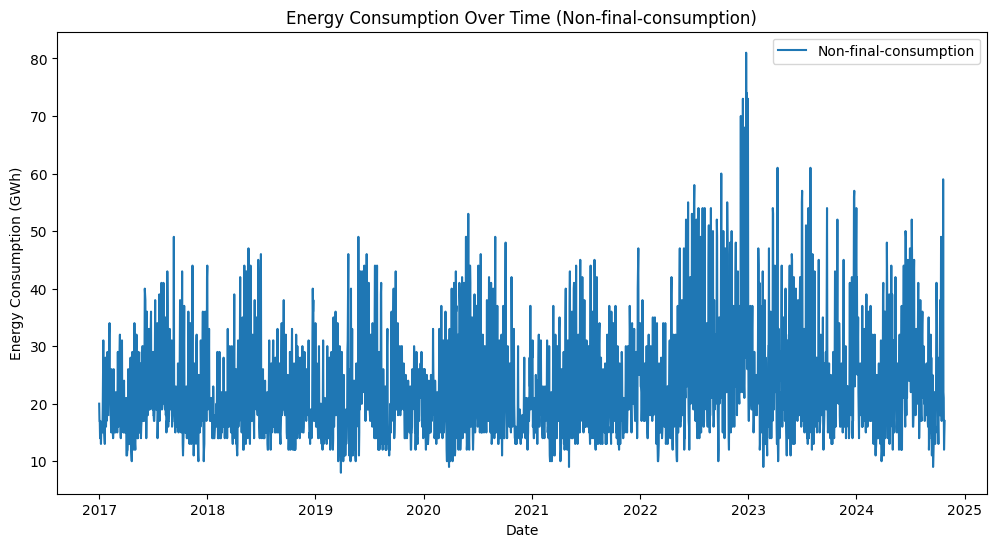

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df["Datum"], df["Landesverbrauch_GWh"]-df["Endverbrauch_GWh"], label="Non-final-consumption", color=colors["Landesverbrauch_GWh"])
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy Consumption (GWh)")
plt.title("Energy Consumption Over Time (Non-final-consumption)")
plt.show()